In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important; }</style>"))

In [3]:
import warnings
warnings.simplefilter(action='ignore')

In [4]:
import seaborn as sns
import matplotlib.mlab as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker

def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=False):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "in",
                 "ytick.direction": "in"})
    rcparams = {'text.usetex': usetex,
              'font.family': 'sans-serif',
              'font.sans-serif': ['Helvetica'],
             # 'text.latex.unicode': True,
              'text.latex.preamble': [r"\usepackage[T1]{fontenc}",
                                      r"\usepackage{lmodern}",
                                      r"\usepackage{amsmath}",
                                      r"\usepackage{mathptmx}"
                                      ],
              'axes.labelsize': 30,
              'axes.titlesize': 30,
              'ytick.right': 'on',
              'xtick.top': 'on',
              'xtick.labelsize': '25',
              'ytick.labelsize': '25',
              'axes.linewidth': 1.8,
              'xtick.major.width': 1.8,
              'xtick.minor.width': 1.8,
              'xtick.major.size': 14,
              'xtick.minor.size': 7,
              'xtick.major.pad': 10,
              'xtick.minor.pad': 10,
              'ytick.major.width': 1.8,
              'ytick.minor.width': 1.8,
              'ytick.major.size': 14,
              'ytick.minor.size': 7,
              'ytick.major.pad': 10,
              'ytick.minor.pad': 10,
              'axes.labelpad': 15,
              'axes.titlepad': 15,
              "xtick.direction": "in",
              "ytick.direction": "in",
              'legend.fontsize': 20}
    mpl.rcParams.update(rcparams) 

mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['lines.color'] = '#3690c0'

stdrcparams(usetex=True)
figsize=stdfigsize(ratio=-1)
xs,ys=figsize

def custom_frame(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.tick_params(axis='x',length=10,direction='out')
    ax.tick_params(axis='x',which='minor',direction='out')
    ax.tick_params(axis='y',length=10,direction='out')
    ax.tick_params(axis='y',which='minor',direction='out')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random

from datetime import date

In [6]:
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix,balanced_accuracy_score

## load data

In [9]:
data = pd.read_pickle('../results/us_air_data_binary_removal.pkl').replace([np.inf, -np.inf], np.nan).dropna(how='all')
# data['passenges_centrality'] = data['passenges_centrality'].astype(np.int64)
data = data[data.year>=date(2004,1,1)]
rename_dict = {}
for column in data.columns:
    if '_index' in column:
        column_v = column.replace('_index','',1)
    else:
        column_v =  column
    rename_dict[column]=column_v.replace('_',' ',3).title()
    
rename_again = {'Common Neighbor' : 'CN', 'Salton':'SA' , 'Jaccard':'JA', 'Sorensen':'SO', 'Hub Promoted':'HPI',
       'Hub Depressed':'HDI', 'Leicht Holme Newman':'LHNI', 'Preferential Attachment':'PA',
       'Adamic Adar':'AA', 'Resource Allocation':'RA', 'Local Path':'LP'}
    
data_air = data.rename(columns=rename_dict).rename(columns={'Prederential Attachment':'Preferential Attachment'})

columns=['Common Neighbor', 'Salton', 'Jaccard', 'Sorensen', 'Hub Promoted',
       'Hub Depressed', 'Leicht Holme Newman', 'Preferential Attachment',
       'Adamic Adar', 'Resource Allocation', 'Local Path',
        'Year','Edge','Time','Label']

data_air =  data_air[columns].rename(columns=rename_again)
data_air = data_air[['Year','Edge','Time','Label']]

In [10]:
data_air.head()

,Year,Edge,Time,Label
767643,2004-01-01,"(aberdeen_sd, minneapolis_mn)",0,0
767644,2004-01-01,"(aberdeen_sd, pierre_sd)",0,0
767645,2004-01-01,"(aberdeen_sd, sioux_falls_sd)",0,0
767646,2004-01-01,"(minneapolis_mn, albany_ny)",0,0
767647,2004-01-01,"(minneapolis_mn, albuquerque_nm)",0,0


In [11]:
dist_df = pd.read_pickle('../data/us_air_distance.pkl')
dict_dist = dist_df.set_index(['source_origin','target_origin']).to_dict()['distance']
dict_dist.update(dist_df.set_index(['target_origin','source_origin']).to_dict()['distance'])
pop_dict = pd.read_pickle('../data/us_air_population_all.pkl').fillna(0).to_dict()[0]
def get_dist(edge):
    return (dict_dist[edge])
def get_pop(node):
    return (pop_dict[node])
def get_G(ni,nj,):
    a,b=edge
    return (get_pop(a)*get_pop(b)/get_dist(edge)**2)

In [12]:
data_air['r'] = data_air.apply(lambda row: get_dist(row.Edge), axis=1)
data_air['ni'] = data_air.apply(lambda row: get_pop(row.Edge[0]), axis=1)
data_air['nj'] = data_air.apply(lambda row: get_pop(row.Edge[1]), axis=1)
data_air['G'] = data_air.ni*data_air.nj/data_air.r**2

In [13]:
data_air.dropna(subset=['G'])
data_air.head()

,Year,Edge,Time,Label,r,ni,nj,G
767643,2004-01-01,"(aberdeen_sd, minneapolis_mn)",0,0,257.0,26091.0,382578.0,151127.838393
767644,2004-01-01,"(aberdeen_sd, pierre_sd)",0,0,117.0,26091.0,13646.0,26009.042735
767645,2004-01-01,"(aberdeen_sd, sioux_falls_sd)",0,0,153.0,26091.0,153888.0,171519.151096
767646,2004-01-01,"(minneapolis_mn, albany_ny)",0,0,979.0,382578.0,97856.0,39060.884048
767647,2004-01-01,"(minneapolis_mn, albuquerque_nm)",0,0,981.0,382578.0,545852.0,216998.575853


In [14]:
def get_result(year):
    df = data_air[data_air.Year==year].sort_values(by='G')
    n_remove = len(df[df.Label==1])
    df['Label_predicted'] = [1]*n_remove + [0]*(len(df)-n_remove)

    y_test = df.Label
    y_predict =df.Label_predicted
    y_null = [i for i in y_test]
    np.random.shuffle(y_null)

    cm = confusion_matrix(y_test,y_predict,labels = [0,1])
    cm = cm.astype('float') / cm.sum(axis = 1)[:,None]
    accuracy = (cm[0,0]+cm[1,1])/2
    
    cm_null = confusion_matrix(y_test,y_null,labels = [0,1])
    cm_null = cm_null.astype('float') / cm_null.sum(axis = 1)[:,None]
    accuracy_null = (cm_null[0,0]+cm_null[1,1])/2
    return(cm,accuracy,cm_null,accuracy_null)

In [15]:
def pure_plot_confusion_matrix(cm, ax = None):
    classes = ['Retained','Removed']
    #classes = [0,1]
    sns.heatmap(cm, square = True, annot= True, cbar = False, cmap=plt.cm.Blues,ax = ax,annot_kws={"fontsize":25})
    ax.set_ylim(0,2)
    ax.tick_params( bottom=False, right=False,left=False, labeltop=False, labelbottom=True)
    ax.invert_yaxis()
    ax.set(xticks = np.arange(cm.shape[1])+0.5,
           yticks = np.arange(cm.shape[0])+0.25,
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel = 'True label',
           xlabel = 'Predicted label')

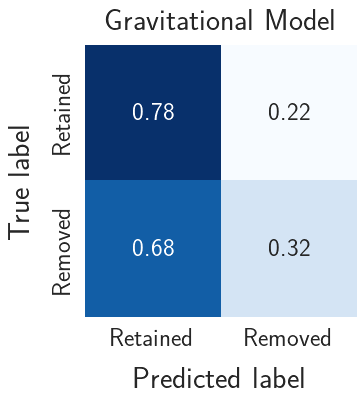

In [16]:
year = date(2004,1,1)
cm,accuracy,cm_null,accuracy_null = get_result(year)
ig,ax =plt.subplots(figsize=(5,5))
plt.title("Gravitational Model")
pure_plot_confusion_matrix(cm,ax=ax)
plt.savefig('../Figs/Fig.SI_gravitation_cm.pdf',transparent=True)

plt.show()

In [17]:
def get_all_results(data):
    accuracies,accuracies_null=[],[]
    for year in data.Year.unique():
        cm,ac,cm_null,ac_null = get_result(year)
        accuracies.append(ac)
        accuracies_null.append(ac_null)
    return(accuracies,accuracies_null)
accuracies,accuracies_null = get_all_results(data_air)

## split edges into training and testing

In [20]:
def get_edge_slice(data,f_train_e=0.7,seed=30):
    df = data
    edges = list(df.Edge.unique())
    random.seed(seed)
    edge_train = random.sample(edges,int(f_train_e*len(edges)))
    edge_test = [e for e in edges if e not in edge_train]
    df_se = df.loc[df['Edge'].isin(edge_train)].drop(columns = ['Edge','Time'])
    df_de = df.loc[df['Edge'].isin(edge_test)].drop(columns = ['Edge','Time'])
    return(df_se,df_de)

def get_time_slice(data,time_start,time_end,droptime=True):
    if droptime:
        return(data[data.Year >= time_start][data.Year <= time_end].drop(columns = ['Year']))
    else:
        return(data[data.Year >= time_start][data.Year <= time_end])
    
def df_to_XY(df):
    if 'Year' in df.columns: 
        df = df.drop(columns = ['Year'])
        if "Edge" in df.columns:
            df = df.drop(columns = ['Edge'])
    X,y = df.loc[:, df.columns != 'Label'].to_numpy(),\
    df.loc[:, df.columns == 'Label'].to_numpy()
    return(X,y)

In [18]:
data = pd.read_pickle('../results/us_air_data_binary_removal.pkl').replace([np.inf, -np.inf], np.nan).dropna(how='all')
# data['passenges_centrality'] = data['passenges_centrality'].astype(np.int64)
data = data[data.year>=date(2004,1,1)]
rename_dict = {}
for column in data.columns:
    if '_index' in column:
        column_v = column.replace('_index','',1)
    else:
        column_v =  column
    rename_dict[column]=column_v.replace('_',' ',3).title()
    
rename_again = {'Common Neighbor' : 'CN', 'Salton':'SA' , 'Jaccard':'JA', 'Sorensen':'SO', 'Hub Promoted':'HPI',
       'Hub Depressed':'HDI', 'Leicht Holme Newman':'LHNI', 'Preferential Attachment':'PA',
       'Adamic Adar':'AA', 'Resource Allocation':'RA', 'Local Path':'LP'}
    
data_ml = data.rename(columns=rename_dict).rename(columns={'Prederential Attachment':'Preferential Attachment'})

columns=['Common Neighbor', 'Salton', 'Jaccard', 'Sorensen', 'Hub Promoted',
       'Hub Depressed', 'Leicht Holme Newman', 'Preferential Attachment',
       'Adamic Adar', 'Resource Allocation', 'Local Path',
        'Year','Edge','Time','Label']

data_ml =  data_ml[columns].rename(columns=rename_again)

In [21]:
air_se,air_de = get_edge_slice(data_ml)
# air_train_start_time = date(2004,1,1)
# air_train_end_time = date(2011,1,1)
# air_train = get_time_slice(air_se,air_train_start_time,air_train_end_time,droptime=False)
# air_test = get_time_slice(air_de,air_train_start_time,air_train_end_time,droptime=False)

In [22]:
def temporal_general_test(df_train,df_test,year_train=date(2004,1,1)):
    year_list = list(df_test.Year.unique())
    X_train,y_train = df_to_XY(df_train[df_train.Year==year_train])   
    ros = RandomUnderSampler()
    X_resampled, y_resampled = ros.fit_resample(X_train,y_train)
    y_train_shuffled = np.copy(y_train)
    np.random.shuffle(y_train_shuffled)
    ros = RandomUnderSampler()
    Xnull_resampled, ynull_resampled = ros.fit_resample(X_train,y_train_shuffled)
    model = XGBClassifier()
    model.fit(X_resampled,y_resampled)
    null = XGBClassifier()
    null.fit(Xnull_resampled,ynull_resampled)
    accuracy,accuracy_null=[],[]
    i = year_list.index(year_train)
    for year_test in year_list[i:]:
        X_test,y_test = df_to_XY(df_test[df_test.Year==year_test])
        y_pred = model.predict(X_test)
        y_pred_null = null.predict(X_test)            
        accuracy.append(balanced_accuracy_score(y_test,y_pred))
        accuracy_null.append(balanced_accuracy_score(y_test,y_pred_null))
    return(accuracy,accuracy_null)

In [23]:
warnings.simplefilter(action='ignore')

In [27]:
air_temporal = temporal_general_test(air_se,air_de)

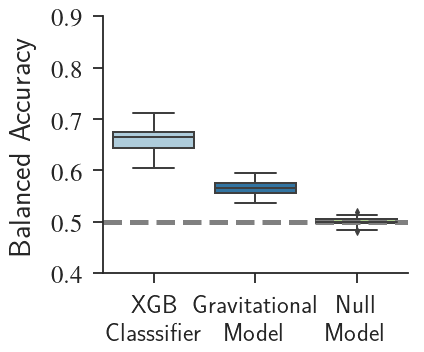

In [28]:
df = pd.concat([pd.DataFrame(dict(Model='XGB \n Classsifier',Accuracy=air_temporal[0])),
                pd.DataFrame(dict(Model='Gravitational \n Model',Accuracy=accuracies)),                               
                pd.DataFrame(dict(Model='Null \n Model',Accuracy=accuracies_null))])
fig,ax = plt.subplots(figsize=(6,5))
ax = sns.boxplot(x="Model", y="Accuracy",palette='Paired', data=df,ax=ax,linewidth=2)
plt.xticks(rotation=0, ha='center')
custom_frame(ax)
plt.ylabel('Balanced\ Accuracy')
plt.xlabel('')
plt.tight_layout()
ax.axhline(y=0.5, linestyle = '--',color ='grey')
plt.ylim(0.4,0.9)
plt.savefig('../Figs/Fig.SI_gravitation_all.pdf',transparent=True)
plt.show()

In [22]:
air_general = temporal_general_test(air_se,air_de)